In [1]:
# single

In [2]:
# dependency
import numpy as np
import pandas as pd
import copy
import math
import sys
import os
from activations import relu, leaky_relu, sigmoid, tanh, softmax, d_sigmoid, d_relu
from initializers import glorot_uniform, random_normal, random_uniform
from regularizers import l1_regularizer, l2_regularizer
from utility import trim_tail, multiply, subtract, get_nparams, one_hot_encoding, get_data
from metrics import MSE, CCE, ACC, PRECISION, RECALL, essential_metrics, wondering_penalty, close_gap_penalty
from pso import PSO
from ga import GA
from nn import Network
from layer import DenseLayer
from scalers import MinMaxScaler, StandardScaler

In [3]:
# reference
metrics_fn_dict = dict()
metrics_fn_dict['accuracy'] = ACC
metrics_fn_dict['categorical_crossentropy'] = CCE
metrics_fn_dict['mean_square_error'] = MSE
metrics_fn_dict['precision'] = PRECISION
metrics_fn_dict['recall'] = RECALL
metrics_fn_dict['essential_metrics'] = essential_metrics

In [4]:
# model
model = Network(5, lr = None)
model.add_layer(DenseLayer(1, 4, True, afn=sigmoid, dafn=None, rfn=None))
model.add_layer(DenseLayer(2, 3, True, afn=softmax, dafn=None, rfn=None))

In [5]:
# optimizer
ga = GA(
    dict(
        m = 200,
        x_rate = [0.5, 1.0],
        m_rate = [0.5, 1.0],
        weight_constraint = [-3.,3.],
        radioactive_rating = [0.1, 0.5],
        grow_factor = [0.1, 0.5],
        scale_hyperparameter = False,
        regularizer = None))

In [6]:
model.compile(loss_fn = 'categorical_crossentropy', optimizer = ga, \
    metrics = ['accuracy', 'mean_square_error', 'categorical_crossentropy', 'precision', 'recall', 'f1'])

building layer 1 with 5
24
building layer 2 with 4
15


In [7]:
# data loading
DATA = os.path.join('c:\\Users\\AI-lab\\github_repo\\neural-network\\', 'dataset')
GROUP = 1
COLUMNS = ['f1', 'f2', 'f3', 'f4', 'f5', 'label']
N_CLASS = 3
EPOCHS = 500
train_dir, test_dir = "..//dataset//training_data{}.txt".format(GROUP), "..//dataset//testing_data{}.txt".format(GROUP)
train, test = get_data(DATA, train_dir, COLUMNS), get_data(DATA, test_dir, COLUMNS)
# shuffle
train, test = train.sample(frac=1), test.sample(frac=1)
x_train, y_train = train.drop('label', axis=1), train['label']
x_test, y_test = test.drop('label', axis=1), test['label']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107 entries, 0 to 106
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      107 non-null    float32
 1   f2      107 non-null    float32
 2   f3      107 non-null    float32
 3   f4      107 non-null    float32
 4   f5      107 non-null    float32
 5   label   107 non-null    float32
dtypes: float32(6)
memory usage: 2.6 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108 entries, 0 to 107
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      108 non-null    float32
 1   f2      108 non-null    float32
 2   f3      108 non-null    float32
 3   f4      108 non-null    float32
 4   f5      108 non-null    float32
 5   label   108 non-null    float32
dtypes: float32(6)
memory usage: 2.7 KB
None


In [8]:
# data scaling and encoding
scaler = StandardScaler(['f1', 'f2', 'f3', 'f4', 'f5'])
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)
y_train = one_hot_encoding(y_train, N_CLASS)
y_test = one_hot_encoding(y_test, N_CLASS)

In [9]:
# learning phase
breakpoint = 100
checkpoints = list()
history = list()
for century in range(0, EPOCHS, breakpoint):
    sub_history = model.fit(x_train, y_train, breakpoint, verbose = 0)
    score = model.evaluate(x_test, y_test, False, verbose = 0)
    print('Checkpoint {}, Accuracy: {}, Loss: {}'.format(century+breakpoint, score['accuracy'], score[model.loss_fn]))
    score['checkpoint'] = century + breakpoint
    checkpoints.append(score)
    history.extend(sub_history)
    itr = century + breakpoint

    model.optimizer.rr = model.optimizer.radioactive_rating[1] - (model.optimizer.radioactive_rating[1] - model.optimizer.radioactive_rating[0]) / EPOCHS * (EPOCHS - itr)
    model.optimizer.gf = model.optimizer.grow_factor[1] - (model.optimizer.grow_factor[1] - model.optimizer.grow_factor[0]) / EPOCHS * (EPOCHS - itr)
    model.optimizer.crossover_rate = model.optimizer.x_rate[1] - (model.optimizer.x_rate[1] - model.optimizer.x_rate[0]) / EPOCHS * (EPOCHS - itr)
    model.optimizer.mutation_rate = model.optimizer.m_rate[0] + (model.optimizer.m_rate[1] - model.optimizer.m_rate[0]) / EPOCHS * (EPOCHS - itr)

C:\Users\AI-lab\github_repo\neural-network\python\ga.py:197: RuntimeWarning: overflow encountered in add
  self.population.sort(key=lambda p: p.fitness + np.random.uniform(-shift, shift, 1), reverse = self.aim)


Checkpoint 100, Accuracy: 0.9753086419753086, Loss: 0.17277004100658275
Checkpoint 200, Accuracy: 0.9691358024691358, Loss: 0.14855019251505533
Checkpoint 300, Accuracy: 0.9691358024691358, Loss: 0.13746237754821777
Checkpoint 400, Accuracy: 0.9691358024691358, Loss: 0.1247878869374593
Checkpoint 500, Accuracy: 0.9753086419753086, Loss: 0.11918748749627008


In [10]:
print(history)

[{'accuracy': 0.7819314641744548, 'mean_square_error': 2.8087387326916784, 'categorical_crossentropy': 0.7718119398455754, 'precision': 0.6728971962616822, 'recall': 0.6728971962616822, 'f1': 0.6728971962616822, 'essential_metrics': {0: {'tp_hit': 65, 'fp_hit': 21, 'tn_hit': 16, 'fn_hit': 5}, 1: {'tp_hit': 0, 'fp_hit': 0, 'tn_hit': 87, 'fn_hit': 20}, 2: {'tp_hit': 7, 'fp_hit': 14, 'tn_hit': 76, 'fn_hit': 10}}}, {'accuracy': 0.8006230529595015, 'mean_square_error': 0.3953433899211983, 'categorical_crossentropy': 0.6778901002117407, 'precision': 0.7009345794392523, 'recall': 0.7009345794392523, 'f1': 0.7009345794392523, 'essential_metrics': {0: {'tp_hit': 60, 'fp_hit': 18, 'tn_hit': 19, 'fn_hit': 10}, 1: {'tp_hit': 0, 'fp_hit': 0, 'tn_hit': 87, 'fn_hit': 20}, 2: {'tp_hit': 15, 'fp_hit': 14, 'tn_hit': 76, 'fn_hit': 2}}}, {'accuracy': 0.8006230529595015, 'mean_square_error': 0.3953433899211983, 'categorical_crossentropy': 0.6778901002117407, 'precision': 0.7009345794392523, 'recall': 0.700

In [11]:
train_acc = [h['accuracy'] for h in history]
train_mse = [h['mean_square_error'] for h in history]
train_cce = [h['categorical_crossentropy'] for h in history]

In [12]:
import matplotlib.pyplot as plt

def draw_plot(x, y_list, x_label=None, y_label=None, legend=None, title=None):
    fig, ax = plt.subplots(figsize=(12,5))
    for xi, yi in zip(x, y_list):
        ax.plot(xi, yi)
    if x_label is not None and y_label is not None:
        ax.set(xlabel=x_label, ylabel=y_label, title='{} VS {}'.format(x_label, y_label))
    if legend is not None:
        ax.legend(legend)
    ax.grid()
    plt.show()

In [13]:
# recall phase
score = model.evaluate(x_test, y_test, False)
print(score)

[1. 0. 0.] <-> [8.6444485e-01 3.9913581e-04 1.3515610e-01]
[0. 1. 0.] <-> [0.84548926 0.13997601 0.01453475]
[1. 0. 0.] <-> [9.5710880e-01 4.0398556e-04 4.2487174e-02]
[1. 0. 0.] <-> [0.98553514 0.00183647 0.01262847]
[1. 0. 0.] <-> [9.4700795e-01 4.2020596e-04 5.2571792e-02]
[1. 0. 0.] <-> [0.98874366 0.00210636 0.00914998]
[0. 0. 1.] <-> [6.3028926e-01 2.9228142e-04 3.6941847e-01]
[1. 0. 0.] <-> [9.7068453e-01 4.5608293e-04 2.8859451e-02]
[1. 0. 0.] <-> [0.9890258  0.00301137 0.00796297]
[1. 0. 0.] <-> [0.98117024 0.00174579 0.01708398]
[1. 0. 0.] <-> [8.6256671e-01 5.8590400e-04 1.3684742e-01]
[1. 0. 0.] <-> [0.9847837  0.00543923 0.00977708]
[1. 0. 0.] <-> [9.7719336e-01 7.7207934e-04 2.2034526e-02]
[1. 0. 0.] <-> [0.9882373  0.00168805 0.01007468]
[1. 0. 0.] <-> [0.98795563 0.0019836  0.01006074]
[0. 1. 0.] <-> [8.8308835e-03 9.9114120e-01 2.7900911e-05]
[1. 0. 0.] <-> [9.7053301e-01 6.0345064e-04 2.8863555e-02]
[1. 0. 0.] <-> [9.7721821e-01 6.8340410e-04 2.2098409e-02]
[1. 0. 0.]

In [14]:
# Testing Performance

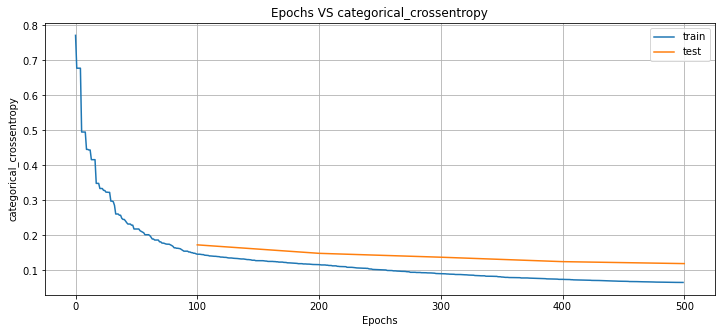

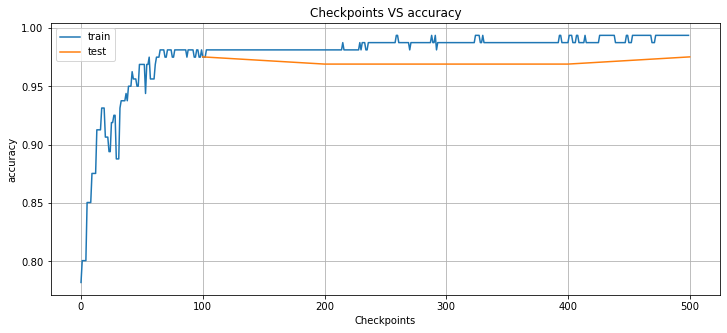

In [15]:
draw_plot(x = [[i for i in range(len(history))], [(i+1)*breakpoint for i in range(len(checkpoints))]], y_list = [train_cce, [ ckp[model.loss_fn] for ckp in checkpoints ]], x_label = 'Epochs', \
    y_label = model.loss_fn, legend=['train', 'test'])
acc = [ ckp['accuracy'] for ckp in checkpoints ]
draw_plot(x = [[i for i in range(len(history))], [(i+1)*breakpoint for i in range(len(checkpoints))]], y_list = [train_acc, acc], x_label = 'Checkpoints', \
    y_label = 'accuracy', legend=['train', 'test'])

In [16]:
for checkpoint in checkpoints:
    print(checkpoint, '\n\n')

{'accuracy': 0.9753086419753086, 'mean_square_error': 0.08141367564693446, 'categorical_crossentropy': 0.17277004100658275, 'precision': 0.9629629629629629, 'recall': 0.9629629629629629, 'f1': 0.9629629629629629, 'essential_metrics': {0: {'tp_hit': 79, 'fp_hit': 3, 'tn_hit': 25, 'fn_hit': 1}, 1: {'tp_hit': 13, 'fp_hit': 0, 'tn_hit': 93, 'fn_hit': 2}, 2: {'tp_hit': 12, 'fp_hit': 1, 'tn_hit': 94, 'fn_hit': 1}}, 'checkpoint': 100} 


{'accuracy': 0.9691358024691358, 'mean_square_error': 0.07269571843194181, 'categorical_crossentropy': 0.14855019251505533, 'precision': 0.9537037037037037, 'recall': 0.9537037037037037, 'f1': 0.9537037037037037, 'essential_metrics': {0: {'tp_hit': 79, 'fp_hit': 4, 'tn_hit': 24, 'fn_hit': 1}, 1: {'tp_hit': 12, 'fp_hit': 0, 'tn_hit': 93, 'fn_hit': 3}, 2: {'tp_hit': 12, 'fp_hit': 1, 'tn_hit': 94, 'fn_hit': 1}}, 'checkpoint': 200} 


{'accuracy': 0.9691358024691358, 'mean_square_error': 0.07216117167788554, 'categorical_crossentropy': 0.13746237754821777, 'preci

In [17]:
print(model)

Layer 1
Neuron 0: weights:
[-0.02086102  2.9881036   1.7145331  -2.8415182  -3.        ]
 bias: 3.0

Neuron 1: weights:
[ 1.2898916 -2.4057987 -1.794701  -0.6177964  1.3225311]
 bias: 1.748854160308838

Neuron 2: weights:
[ 2.010213  -2.9951723 -3.        -1.5297557 -1.3002   ]
 bias: 1.2329131364822388

Neuron 3: weights:
[ 2.0351195  -2.6620994  -0.29687515  0.48204377  1.0961969 ]
 bias: 1.217281699180603

$
Layer 2
Neuron 0: weights:
[3.         0.60158956 3.         0.11815149]
 bias: -3.0

Neuron 1: weights:
[ 2.4200928 -3.        -3.        -3.       ]
 bias: 2.3009870052337646

Neuron 2: weights:
[-3.         1.81947    1.0695643  3.       ]
 bias: -2.7577645778656006

$

